<a href="https://colab.research.google.com/github/nisaruj/Chemception-plus/blob/master/Chemception_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Activation, Conv2D, Concatenate, Add, MaxPooling2D
from keras.utils.vis_utils import plot_model


inputs = Input(shape=(80, 80, 1))

# Stem Block

(None, 18, 18, 160)
(None, 16, 16, 192)
Model: "Stem"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 80, 80, 1)]  0                                            
__________________________________________________________________________________________________
Stem_c0 (Conv2D)                (None, 39, 39, 32)   320         input_31[0][0]                   
__________________________________________________________________________________________________
Stem_c1 (Conv2D)                (None, 37, 37, 32)   9248        Stem_c0[0][0]                    
__________________________________________________________________________________________________
Stem_c2 (Conv2D)                (None, 37, 37, 64)   18496       Stem_c1[0][0]                    
_______________________________________________________

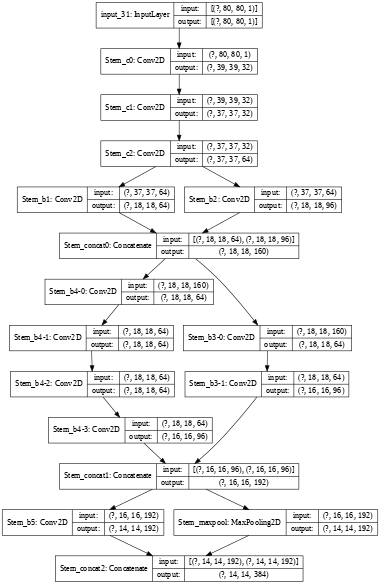

In [57]:
def Stem(name, inputs):
    hidden = Conv2D(32, (3, 3), 2, 'valid', name=name + '_c0')(inputs)
    hidden = Conv2D(32, (3, 3), 1, 'valid', name=name + '_c1')(hidden)
    hidden = Conv2D(64, (3, 3), 1, 'same',  name=name + '_c2')(hidden)

    b1 = Conv2D(64, (3, 3), 2, 'valid', name=name + '_b1')(hidden)
    b2 = Conv2D(96, (3, 3), 2, 'valid', name=name + '_b2')(hidden)

    concat0 = Concatenate(name=name + '_concat0')([b1, b2])
    print(concat0.shape)

    b3_0 = Conv2D(64, (1, 1), 1, 'same',  name=name + '_b3-0')(concat0)
    b3_1 = Conv2D(96, (3, 3), 1, 'valid', name=name + '_b3-1')(b3_0)
    b4_0 = Conv2D(64, (1, 1), 1, 'same',  name=name + '_b4-0')(concat0)
    b4_1 = Conv2D(64, (7, 1), 1, 'same',  name=name + '_b4-1')(b4_0)
    b4_2 = Conv2D(64, (1, 7), 1, 'same',  name=name + '_b4-2')(b4_1)
    b4_3 = Conv2D(96, (3, 3), 1, 'valid', name=name + '_b4-3')(b4_2)

    concat1 = Concatenate(name=name + '_concat1')([b3_1, b4_3])
    print(concat1.shape)

    b5 = Conv2D(192, (3, 3), 1, 'valid', name = name + '_b5')(concat1)
    b6 = MaxPooling2D(3, (1, 1), padding='valid', name=name + '_maxpool')(concat1)

    concat2 = Concatenate(name=name + '_concat2')([b5, b6])
    return concat2

stem = Stem('Stem', inputs)
model = Model(inputs=inputs, outputs=stem, name='Stem')
model.summary()
plot_model(model, show_shapes=True, dpi=40)

# Inception ResNet A

Model: "Inception ResNet A"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 80, 80, 1)]  0                                            
__________________________________________________________________________________________________
BlockA_relu1 (Activation)       (None, 80, 80, 1)    0           input_31[0][0]                   
__________________________________________________________________________________________________
BlockA_b3-0 (Conv2D)            (None, 80, 80, 16)   32          BlockA_relu1[0][0]               
__________________________________________________________________________________________________
BlockA_b2-0 (Conv2D)            (None, 80, 80, 16)   32          BlockA_relu1[0][0]               
_________________________________________________________________________________

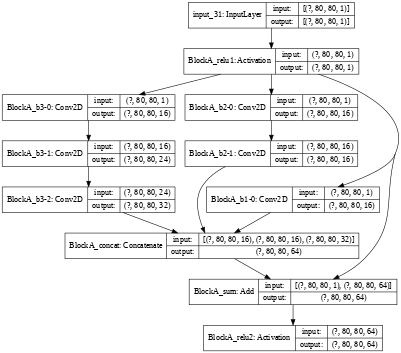

In [58]:
def Inception_ResNet_A(name, N, inputs):
    relu1 = Activation('relu', name=name+'_relu1')(inputs)

    # red branch
    branch1 = Conv2D(filters=N, 
                     kernel_size=(1, 1),
                     padding="same",
                     activation='relu',
                     name=name+'_b1-0')(relu1)

    # green branch
    hidden = Conv2D(filters=N, 
                    kernel_size=(1, 1),
                     padding="same",
                    activation='relu',
                    name=name+'_b2-0')(relu1)
    branch2 = Conv2D(filters=N, 
                     kernel_size=(3, 3),
                     padding="same",
                     activation='relu',
                     name=name+'_b2-1')(hidden)

    # blue branch
    hidden = Conv2D(filters=N, 
                    kernel_size=(1, 1),
                     padding="same",
                    activation='relu',
                    name=name+'_b3-0')(relu1)
    hidden = Conv2D(filters=1.5 * N, 
                    kernel_size=(3, 3),
                     padding="same",
                    activation='relu',
                    name=name+'_b3-1')(hidden)
    branch3 = Conv2D(filters=2 * N, 
                     kernel_size=(3, 3),
                     padding="same",
                     activation='relu',
                     name=name+'_b3-2')(hidden)

    concat = Concatenate(name=name+'_concat')([branch1, branch2, branch3])
    hidden = Conv2D(filters=N, 
                    kernel_size=(1, 1),
                    padding="same",
                    activation='linear',
                    name=name+'_lienar')(concat)
    sum = Add(name=name+'_sum')([relu1, concat])

    relu2 = Activation('relu', name=name+'_relu2')(sum)

    return relu2

iResNetA = Inception_ResNet_A('BlockA', 16, inputs)
model = Model(inputs=inputs, outputs=iResNetA, name='Inception ResNet A')
model.summary()
plot_model(model, show_shapes=True, dpi=40)